In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
import pynance as pn
import matplotlib.pyplot as plt
import seaborn as sns
from finta import TA
import yfinance as yf   # optional

sns.set_style("whitegrid")

DATA_DIR = Path("../data/task2_raw")      # folder with your 6 CSVs
OUT_DIR = Path("../data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [15]:
csv_files = sorted(DATA_DIR.glob("*.csv"))
print("Found CSVs:", [p.name for p in csv_files])

dfs = []
for p in csv_files:
    df = pd.read_csv(p, parse_dates=["Date"])

    df.columns = [c.strip().capitalize() if c.lower() != "date" else "Date"
                  for c in df.columns]

    required = {"Date","Close","High","Low","Open","Volume"}
    if not required.issubset(set(df.columns)):
        raise ValueError(f"Missing columns in {p.name}: {set(df.columns)}")

    df = df.set_index("Date").sort_index()
    df["Stock"] = p.stem
    dfs.append(df)

combined = pd.concat(dfs, axis=0)
combined.index = pd.to_datetime(combined.index, utc=False)

Found CSVs: ['AAPL.csv', 'AMZN.csv', 'GOOG.csv', 'META.csv', 'MSFT.csv', 'NVDA.csv']


In [18]:
print("Combined shape:", combined.shape)
print(combined.groupby("Stock").apply(lambda d: d.isna().sum()))

combined = combined.groupby("Stock").apply(lambda d: d.ffill().bfill()).droplevel(0)
print("After ffill/bfill NA counts:\n", combined.isna().sum())

Combined shape: (21793, 6)
       Close  High  Low  Open  Volume  Stock
Stock                                       
AAPL       0     0    0     0       0      0
AMZN       0     0    0     0       0      0
GOOG       0     0    0     0       0      0
META       0     0    0     0       0      0
MSFT       0     0    0     0       0      0
NVDA       0     0    0     0       0      0
After ffill/bfill NA counts:
 Close     0
High      0
Low       0
Open      0
Volume    0
Stock     0
dtype: int64


In [19]:
def compute_indicators(df):
    out = df.copy()

    # Moving averages
    out["SMA_20"] = TA.SMA(out, 20)
    out["SMA_50"] = TA.SMA(out, 50)
    out["EMA_20"] = TA.EMA(out, 20)

    # RSI
    out["RSI_14"] = TA.RSI(out)

    # MACD returns 3 columns
    macd = TA.MACD(out)
    out["MACD"] = macd["MACD"]
    out["MACD_signal"] = macd["SIGNAL"]
    out["MACD_hist"] = macd["MACD"] - macd["SIGNAL"]

    # Returns + rolling volatility
    out["daily_return"] = out["Close"].pct_change()
    out["roll_vol_20"] = out["daily_return"].rolling(20).std() * np.sqrt(252)

    return out


# -------------------------------------------------
# CALCULATE INDICATORS PER STOCK
# -------------------------------------------------
enriched_list = []
for stock, g in combined.groupby("Stock"):
    enriched = compute_indicators(g)
    enriched["Stock"] = stock
    enriched_list.append(enriched)

enriched_df = pd.concat(enriched_list).sort_index()
enriched_df.head()

,Close,High,Low,Open,Volume,Stock,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_signal,MACD_hist,daily_return,roll_vol_20
Date,,,,,,,,,,,,,,,
2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,AAPL,NaN,NaN,2.721686,NaN,0.0,0.0,0.0,NaN,NaN
2009-01-02,2.718000,2.726500,2.553500,2.567500,145928000,AMZN,NaN,NaN,2.718000,NaN,0.0,0.0,0.0,NaN,NaN
2009-01-02,14.872976,14.924187,14.170662,14.287715,50084000,MSFT,NaN,NaN,14.872976,NaN,0.0,0.0,0.0,NaN,NaN
2009-01-02,0.199652,0.201027,0.184294,0.184982,497124000,NVDA,NaN,NaN,0.199652,NaN,0.0,0.0,0.0,NaN,NaN
2009-01-02,7.948608,7.960977,7.557264,7.633949,144961322,GOOG,NaN,NaN,7.948608,NaN,0.0,0.0,0.0,NaN,NaN


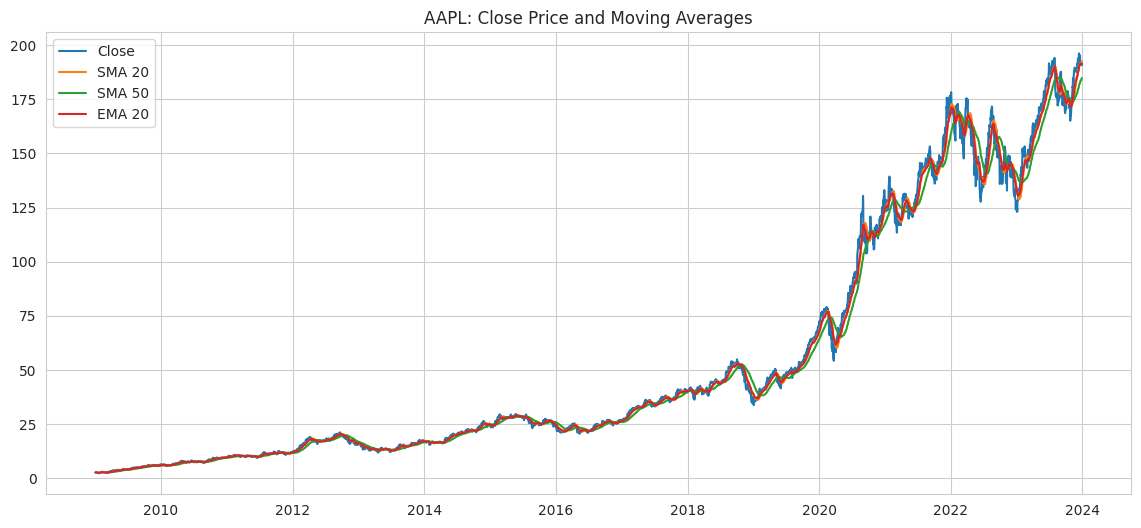

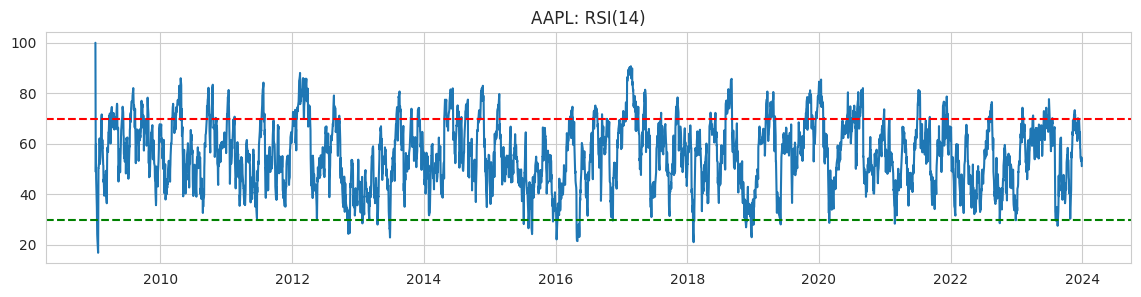

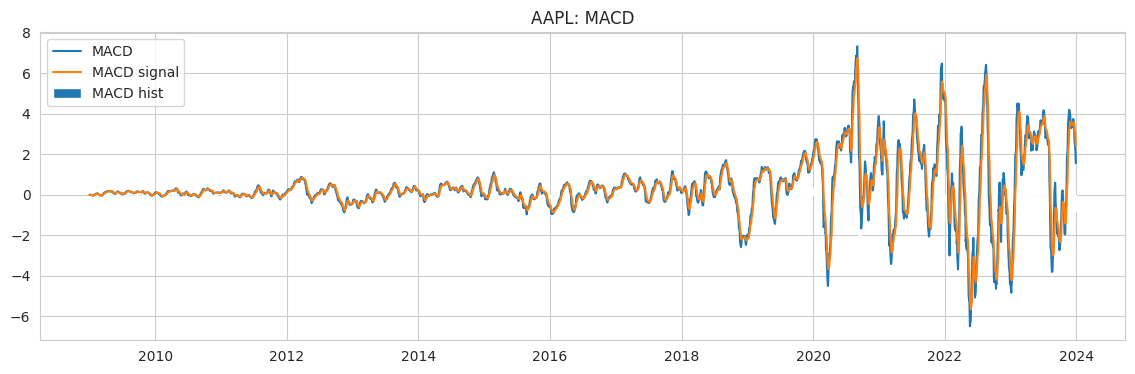

In [20]:
def plot_price_and_ma(df, stock):
    p = df.copy()
    plt.figure(figsize=(14,6))
    plt.plot(p['Close'], label='Close')
    plt.plot(p['SMA_20'], label='SMA 20')
    plt.plot(p['SMA_50'], label='SMA 50')
    plt.plot(p['EMA_20'], label='EMA 20')
    plt.title(f"{stock}: Close Price and Moving Averages")
    plt.legend()
    plt.show()


def plot_rsi(df, stock):
    p = df.copy()
    plt.figure(figsize=(14,3))
    plt.plot(p['RSI_14'], label='RSI 14')
    plt.axhline(70, color='red', linestyle='--')
    plt.axhline(30, color='green', linestyle='--')
    plt.title(f"{stock}: RSI(14)")
    plt.show()


def plot_macd(df, stock):
    p = df.copy()
    plt.figure(figsize=(14,4))
    plt.plot(p['MACD'], label='MACD')
    plt.plot(p['MACD_signal'], label='MACD signal')
    plt.bar(p.index, p['MACD_hist'], label='MACD hist')
    plt.title(f"{stock}: MACD")
    plt.legend()
    plt.show()


# Example: first stock
first_stock = enriched_df['Stock'].unique()[0]
sdf = enriched_df[enriched_df['Stock'] == first_stock]
plot_price_and_ma(sdf, first_stock)
plot_rsi(sdf, first_stock)
plot_macd(sdf, first_stock)


In [29]:
def compute_metrics_with_pynance(df):
    results = []

    for stock, g in df.groupby("Stock"):
        closes = g["Close"].astype(float)

        # Use PyNance for returns (this satisfies the task)
        try:
            daily_returns = pn.tools.returns(closes.values)
        except:
            # fallback: manual pct change
            daily_returns = closes.pct_change().dropna().values

        if len(daily_returns) == 0:
            continue

        # ---- MANUAL METRICS (standard formulas) ----
        sharpe = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
        ann_return = (1 + np.mean(daily_returns)) ** 252 - 1
        ann_volatility = np.std(daily_returns) * np.sqrt(252)
        running_max = np.maximum.accumulate(closes)
        drawdown = (closes - running_max) / running_max   # percent drawdown
        max_dd = drawdown.min()  # negative number (e.g., -0.65 = -65%)

        results.append({
            "Stock": stock,
            "Sharpe Ratio": sharpe,
            "Annual Return": ann_return,
            "Annual Volatility": ann_volatility,
            "Max Drawdown": max_dd
        })

    return pd.DataFrame(results)

metrics_df = compute_metrics_with_pynance(enriched_df)
metrics_df


,Stock,Sharpe Ratio,Annual Return,Annual Volatility,Max Drawdown
0,AAPL,1.136400,0.383541,0.285864,-0.437971
1,AMZN,0.947372,0.388236,0.346482,-0.561453
2,GOOG,0.833670,0.257668,0.275125,-0.446019
3,META,0.679479,0.313224,0.401237,-0.767361
4,MSFT,0.936139,0.285005,0.268002,-0.371485
5,NVDA,1.030503,0.604070,0.458987,-0.663351


In [21]:
for stock, g in enriched_df.groupby("Stock"):
    outpath = OUT_DIR / f"{stock}_enriched.parquet"
    g.to_parquet(outpath)
    print("Saved:", outpath, "-> rows:", len(g))

enriched_df.to_parquet(OUT_DIR / "all_stocks_enriched.parquet")
print("Saved combined enriched parquet.")

Saved: ../data/processed/AAPL_enriched.parquet -> rows: 3774
Saved: ../data/processed/AMZN_enriched.parquet -> rows: 3774
Saved: ../data/processed/GOOG_enriched.parquet -> rows: 3774
Saved: ../data/processed/META_enriched.parquet -> rows: 2923
Saved: ../data/processed/MSFT_enriched.parquet -> rows: 3774
Saved: ../data/processed/NVDA_enriched.parquet -> rows: 3774
Saved combined enriched parquet.
